<a href="https://colab.research.google.com/github/ayyucedemirbas/VLM_presentation/blob/main/finetune_paligemma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetune PaliGemma

> *These models and code are not official Google products and were trained and released for research purposes.*


**This notebook shows how to finetune PaliGemma 2 on a vision-language task.**
The training data consists of 90 pairs of images and long captions describing them.
To make it runnable on a T4 colab runtime with 16GB HBM and 12GB RAM, we opt to only finetune the attention layers of the language model and freeze the other parameters.

 **This setup is illustrative**. In a real usecase, the amount of data, trainable parameters, training steps and hyper-parameters and obtained results could be significantly different.

This notebook uses the model reference implementation from [big_vision](https://github.com/google-research/big_vision).
and shows how to:

 * Install deps, download model checkpoint and training data.
 * Load the model onto GPU devices.
 * Prepare the input to the model for training and inference.
 * Finetune the model and inspect output in validation split.

## Setup

In [1]:
# @title Fetch big_vision code and install dependencies.
import os
import sys

# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 3.5 MB/s eta 0:00:00


### Configure your API key to access Kaggle

To use PaliGemma, you must provide your Kaggle username and a Kaggle API key.

1. To generate a Kaggle API key, go to the **Account** tab of your Kaggle user profile and select **Create New Token**. This will trigger the download of a `kaggle.json` file containing your API credentials.
1. In Colab, select **Secrets** (🔑) in the left pane and add your Kaggle username and Kaggle API key. Store your username under the name `KAGGLE_USERNAME` and your API key under the name `KAGGLE_KEY`.

To be able to download, you will also need to acknowledge the Terms and Conditions of the PaliGemma on:

* https://www.kaggle.com/models/google/paligemma/



In [2]:
import os
from google.colab import userdata
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"username","key":"key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

# The T4 runtime is tight on memory to finetune this model. Preallocate
# all memory ahead of time to avoid OOM'ing due to fragmentation.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

In [3]:
# @title Download checkpoint, tokenizer and dataset to local filesystem.
#
import os
import kagglehub

# Use these for PaliGemma-2 3B 224px²
LLM_VARIANT = "gemma2_2b"
MODEL_PATH = "./paligemma2-3b-pt-224.b16.npz"
KAGGLE_HANDLE = "google/paligemma-2/jax/paligemma2-3b-pt-224"  # Path to fetch from Kaggle.

# Use these for PaliGemma 1:
# LLM_VARIANT = "gemma_2b"
# MODEL_PATH = "./paligemma-3b-pt-224.f16.npz"
# KAGGLE_HANDLE = "google/paligemma/jax/paligemma-3b-pt-224"

if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  MODEL_PATH = kagglehub.model_download(KAGGLE_HANDLE, MODEL_PATH)
  print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
  print(f"Tokenizer path: {TOKENIZER_PATH}")

DATA_DIR="./longcap100"
if not os.path.exists(DATA_DIR):
  print("Downloading the dataset...")
  !gsutil -m -q cp -n -r gs://longcap100/ .
  print(f"Data path: {DATA_DIR}")

100%|██████████| 5.65G/5.65G [06:00<00:00, 16.8MB/s]


Model path: /root/.cache/kagglehub/models/google/paligemma-2/jax/paligemma2-3b-pt-224/1/./paligemma2-3b-pt-224.b16.npz
Copying gs://big_vision/paligemma_tokenizer.model...
\ [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model
Data path: ./longcap100


## Notebook

In [4]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.extend.backend.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.4.33
JAX platform: gpu
JAX devices:  1


In [5]:
# @title Construct model and load params into RAM.

# Define model
# IMPORTANT: Gemma-2 has a "final_logits_softcap" property, we set it to 0.0
# for better transfer results.
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152, "variant": LLM_VARIANT, "final_logits_softcap": 0.0},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

In [6]:
# @title Move params to GPU/TPU memory.
#
# To keep HBM usage low and fit in a T4 GPU (16GB HBM) we opt to only finetune
# a part of the parameters. Additionally we keep the frozen params in float16
# and cast trainable to float32.

# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

#
# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  # Cast others to float16, since some GPUs don't support bf16.
  return jax.tree.map(lambda p, m: p.astype(jnp.float32)
                      if m else p.astype(jnp.float16),
                      params, trainable)

In [7]:
# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default (12GB RAM).
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

In [8]:
# @title Define preprocess functions to create inputs to the model.

def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if its a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


In [9]:
# @title Function to iterate over train and validation examples.
SEQLEN = 128

# TODO: Consider data iterators skipping big_vision and tf.data?
train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "data_train90.jsonl"),
    fopen_keys={"image": DATA_DIR})

val_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "data_val10.jsonl"),
    fopen_keys={"image": DATA_DIR})


def train_data_iterator():
  """Never ending iterator over training examples."""
  # Shuffle examples and repeat so one can train for many epochs.
  dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
  for example in dataset.as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = "caption en"  # Could also be a different prefix per example.
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
    }


def validation_data_iterator():
  """Single iterator over validation examples."""
  for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = "caption en"  # Could also be a different prefix per example.
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }


Training examples



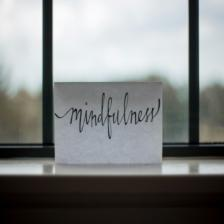
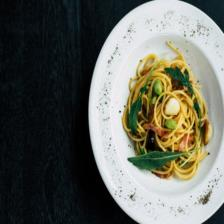
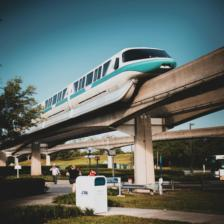
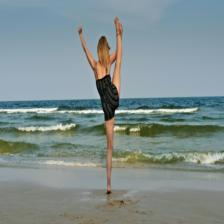
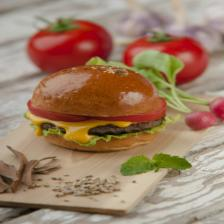
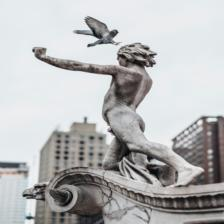
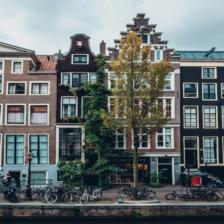
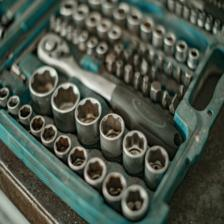

In [10]:
# @title Inspect training examples.
def render_inline(image, resize=(128, 128)):
  """Convert image into inline html."""
  image = Image.fromarray(image)
  image.resize(resize)
  with io.BytesIO() as buffer:
    image.save(buffer, format='jpeg')
    image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
  image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
  return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """

html_out = ""
for idx, example in zip(range(8), train_data_iterator()):
  caption = postprocess_tokens(example["text"])  # detokenize model input.
  caption = caption[len("caption en\n"):]        # strip prefix
  html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

In [11]:
# @title Define the training step and evaluation loop.
#
# The main update_fn using simple SGD.
#
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens we normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, response in zip(examples, responses):
      outputs.append((example["image"], response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

step:  1/64   lr: 0.00500   loss: 3.5107
Model predictions at step 1



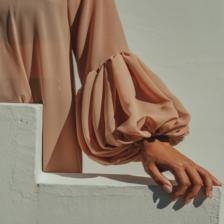
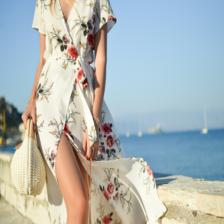
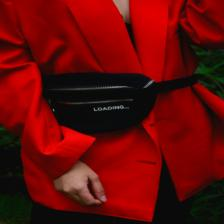
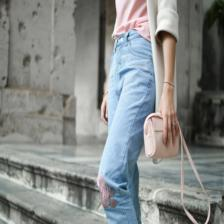

step:  2/64   lr: 0.01000   loss: 1.7144
step:  3/64   lr: 0.01500   loss: 1.6108
step:  4/64   lr: 0.02000   loss: 1.5681
step:  5/64   lr: 0.02500   loss: 1.6915
step:  6/64   lr: 0.03000   loss: 1.8618
step:  7/64   lr: 0.02998   loss: 2.3077
step:  8/64   lr: 0.02992   loss: 2.0764
step:  9/64   lr: 0.02981   loss: 1.7260
step: 10/64   lr: 0.02966   loss: 1.5876
step: 11/64   lr: 0.02947   loss: 1.4825
step: 12/64   lr: 0.02924   loss: 1.2042
step: 13/64   lr: 0.02897   loss: 1.0300
step: 14/64   lr: 0.02866   loss: 1.0467
step: 15/64   lr: 0.02831   loss: 1.3823
step: 16/64   lr: 0.02792   loss: 1.1945
Model predictions at step 16



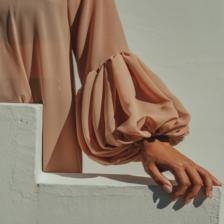
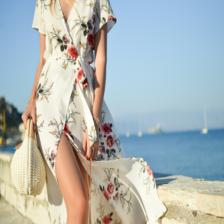
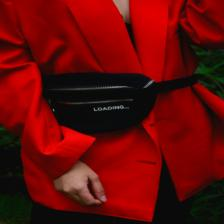
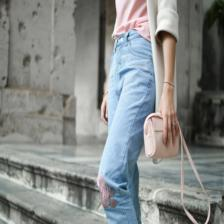

step: 17/64   lr: 0.02750   loss: 1.1177
step: 18/64   lr: 0.02704   loss: 1.1353
step: 19/64   lr: 0.02655   loss: 1.0132
step: 20/64   lr: 0.02602   loss: 1.1024
step: 21/64   lr: 0.02546   loss: 0.9822
step: 22/64   lr: 0.02488   loss: 0.9133
step: 23/64   lr: 0.02426   loss: 0.8656
step: 24/64   lr: 0.02362   loss: 0.6136
step: 25/64   lr: 0.02296   loss: 0.6916
step: 26/64   lr: 0.02227   loss: 0.7728
step: 27/64   lr: 0.02156   loss: 0.7168
step: 28/64   lr: 0.02083   loss: 0.6383
step: 29/64   lr: 0.02009   loss: 0.6628
step: 30/64   lr: 0.01933   loss: 0.7235
step: 31/64   lr: 0.01856   loss: 0.6612
step: 32/64   lr: 0.01778   loss: 0.6303
Model predictions at step 32



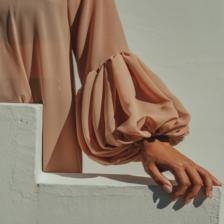
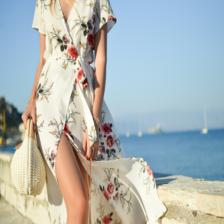
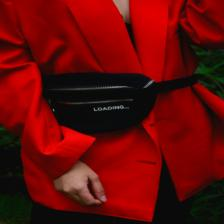
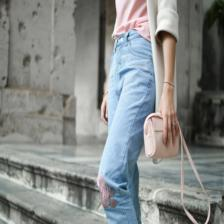

step: 33/64   lr: 0.01699   loss: 0.7203
step: 34/64   lr: 0.01620   loss: 0.6073
step: 35/64   lr: 0.01540   loss: 0.4455
step: 36/64   lr: 0.01460   loss: 0.3508
step: 37/64   lr: 0.01380   loss: 0.3493
step: 38/64   lr: 0.01301   loss: 0.4425
step: 39/64   lr: 0.01222   loss: 0.4424
step: 40/64   lr: 0.01144   loss: 0.4864
step: 41/64   lr: 0.01067   loss: 0.3478
step: 42/64   lr: 0.00991   loss: 0.1960
step: 43/64   lr: 0.00917   loss: 0.3000
step: 44/64   lr: 0.00844   loss: 0.3815
step: 45/64   lr: 0.00773   loss: 0.3564
step: 46/64   lr: 0.00704   loss: 0.1425
step: 47/64   lr: 0.00638   loss: 0.2106
step: 48/64   lr: 0.00574   loss: 0.1866
Model predictions at step 48



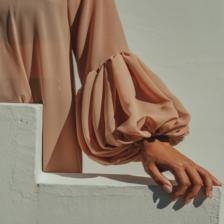
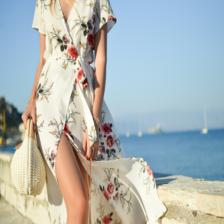
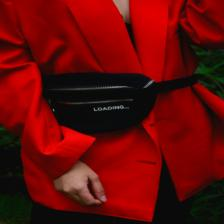
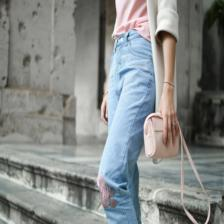

step: 49/64   lr: 0.00512   loss: 0.1386
step: 50/64   lr: 0.00454   loss: 0.1631
step: 51/64   lr: 0.00398   loss: 0.1512
step: 52/64   lr: 0.00345   loss: 0.1748
step: 53/64   lr: 0.00296   loss: 0.1649
step: 54/64   lr: 0.00250   loss: 0.1482
step: 55/64   lr: 0.00208   loss: 0.1033
step: 56/64   lr: 0.00169   loss: 0.2184
step: 57/64   lr: 0.00134   loss: 0.1035
step: 58/64   lr: 0.00103   loss: 0.0661
step: 59/64   lr: 0.00076   loss: 0.1094
step: 60/64   lr: 0.00053   loss: 0.1106
step: 61/64   lr: 0.00034   loss: 0.0910
step: 62/64   lr: 0.00019   loss: 0.0675
step: 63/64   lr: 0.00008   loss: 0.1229
step: 64/64   lr: 0.00002   loss: 0.1478
Model predictions at step 64



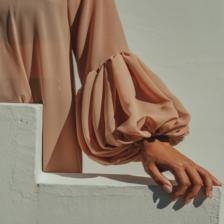
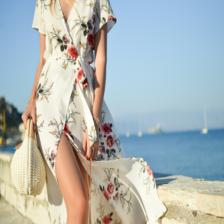
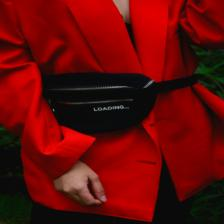
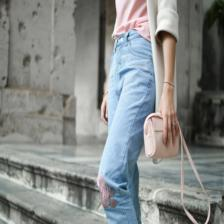

CPU times: user 7min 7s, sys: 11.9 s, total: 7min 19s
Wall time: 17min 19s


In [12]:
# @title Run training loop.
#
# Run a short training loop with cosine learning rate schedule.
#
# Note: the first step can be quite slow on some machines (up to several minutes)
# due to XLA compilation of the jax.jit'd function.
#
%%time

BATCH_SIZE = 8
TRAIN_EXAMPLES = 512
LEARNING_RATE = 0.03

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 4

train_data_it = train_data_iterator()

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)

for step in range(1, TRAIN_STEPS+1):
  # Make list of N training examples.
  examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

  # Convert list of examples into a dict of np.arrays and load onto devices.
  batch = jax.tree.map(lambda *x: np.stack(x), *examples)
  batch = big_vision.utils.reshard(batch, data_sharding)

  # Training step and report training loss
  learning_rate = sched_fn(step)
  params, loss = update_fn(params, batch, learning_rate)

  loss = jax.device_get(loss)
  print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")

  if step == 1 or (step % EVAL_STEPS) == 0:
    print(f"Model predictions at step {step}")
    html_out = ""
    for image, caption in make_predictions(
        validation_data_iterator(), num_examples=4, batch_size=4):
      html_out += render_example(image, caption)
    display(HTML(html_out))


Model predictions



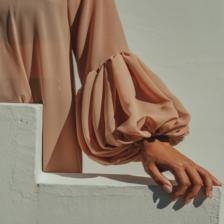
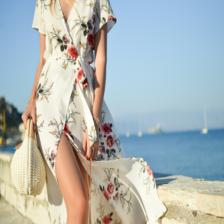
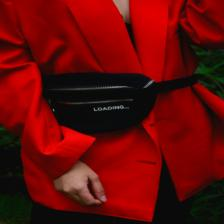
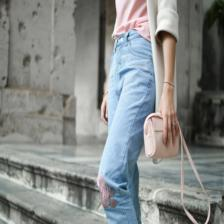
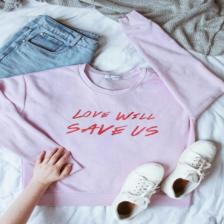
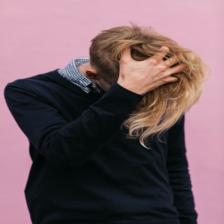
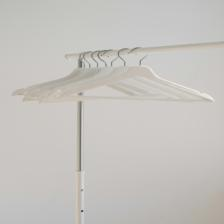
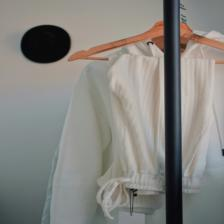
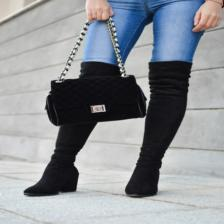
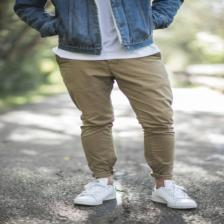

CPU times: user 37.6 s, sys: 296 ms, total: 37.9 s
Wall time: 47.6 s


In [13]:
# @title Evaluate the model on all examples.
#
# The validation data consists of 10 images in a different domain than training
# data.
%%time

print("Model predictions")
html_out = ""
for image, caption in make_predictions(validation_data_iterator(), batch_size=4):
  html_out += render_example(image, caption)
display(HTML(html_out))


# Save the final checkpoint

In [14]:
def npsave(pytree, path):
  names_and_vals, _ = big_vision.utils.tree_flatten_with_names(pytree)
  with open(path, "wb") as f:
    np.savez(f, **{k:v for k, v in names_and_vals})

# Takes around 4 minutes
npsave(params, 'my-custom-paligemma-ckpt.npz')